In [46]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as functional
from torch import optim

In [47]:
def conv3x3(in_channels: int, out_channels: int, padding=0):
	return nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=padding)


def max_pool_2d():
	return nn.MaxPool2d(kernel_size=2, stride=2)

In [48]:
class UnetEncodeLayer(nn.Module):
    # just a standard convolution layer.
	def __init__(self, in_channels: int, out_channels: int, activated=True,max_pool=False, padding=0):
		super(UnetEncodeLayer, self).__init__()
		layers = [
            conv3x3(in_channels, out_channels, padding=padding),
			nn.BatchNorm2d(out_channels),
            # nn.BatchNorm2d(out_channels),
        ]
		if activated:
			layers += [nn.ReLU()]
		if max_pool:
			layers += [max_pool_2d()]
		self.layer = nn.Sequential(*layers)
	
	def forward(self, x):
		return self.layer(x)
	
class UnetUpscaleLayer(nn.Module):
	def __init__(self, scale_factor, in_channels):
		super(UnetUpscaleLayer, self).__init__()
		layers = [
			nn.Upsample(scale_factor = (scale_factor,scale_factor), mode = 'bilinear'),
			conv3x3(in_channels, in_channels//2,padding=1)
		]
		self.layer = nn.Sequential(*layers)
	def forward(self, x):
		return self.layer(x)

class UnetForwardDecodeLayer(nn.Module):
	def __init__(self, in_channels, out_channels, padding=0):
		super(UnetForwardDecodeLayer, self).__init__()
		layers = [
			conv3x3(in_channels=in_channels, out_channels=out_channels, padding=padding),
			nn.ReLU(),
			nn.BatchNorm2d(out_channels),
			conv3x3(in_channels=out_channels, out_channels=out_channels, padding=padding),
			nn.ReLU(),
			nn.BatchNorm2d(out_channels),
		]
		self.layer = nn.Sequential(*layers)
	def forward(self, x):
		return self.layer(x)

In [49]:
class Urnet(nn.Module):	
	def __init__(self):
		super(Urnet, self).__init__()
		self.residuals = []
    	# encoding part of the Unet vanilla architecture
		self.encode1 = nn.Sequential(
			UnetEncodeLayer(3, 64, padding=1),
			UnetEncodeLayer(64, 64, padding=1), ## keep dimensions unchanged
		)
		self.encode2 = nn.Sequential(
			nn.MaxPool2d(kernel_size=2, stride=2),
			UnetEncodeLayer(64, 128, padding=1),
			UnetEncodeLayer(128, 128, padding=1),
		)
		self.encode3 = nn.Sequential(
			nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
			UnetEncodeLayer(128, 256, padding=1),
			UnetEncodeLayer(256, 256, padding=1),
		)
		self.encode4 = nn.Sequential(
			nn.MaxPool2d(kernel_size=2, stride=2),
			UnetEncodeLayer(256, 512, padding=1),
			UnetEncodeLayer(512, 512, padding=1),
		)
		self.encode5 = nn.Sequential(
			nn.MaxPool2d(kernel_size=2, stride=2),
			UnetEncodeLayer(512, 1024, padding=1),
			UnetEncodeLayer(1024, 1024, padding=1),
		)
		self.upscale1 = nn.Sequential(
			UnetUpscaleLayer(2, 1024)
		)
		self.decode_forward1 = nn.Sequential(
			UnetForwardDecodeLayer(1024,512, padding=1)
		)
		self.upscale2 = nn.Sequential(
			UnetUpscaleLayer(2, 512)
		)
		self.decode_forward2 = nn.Sequential(
			UnetForwardDecodeLayer(512, 256, padding=1)
		)
		self.upscale3 = nn.Sequential(
			UnetUpscaleLayer(2,256)
		)
		self.decode_forward3 = nn.Sequential(
			UnetForwardDecodeLayer(256,128,padding=1)
		)
		self.upscale4 = nn.Sequential(
			UnetUpscaleLayer(2,128)
		)
		self.decode_forward4 = nn.Sequential(
			UnetForwardDecodeLayer(128,64, padding=1),
			nn.Conv2d(64, 6, kernel_size=1) # final conv 1x1
			# Model output is 6xHxW, so we have a prob. distribution
			# for each pixel (each pixel has a logit for each of the 6 classes.)
		)	
	def forward(self, x: torch.Tensor):
		self.x1 = self.encode1(x)
		self.x2 = self.encode2(self.x1)
		self.x3 = self.encode3(self.x2)
		self.x4 = self.encode4(self.x3)
		self.x5 = self.encode5(self.x4)

		y1 = self.upscale1(self.x5)
		c1 = torch.concat((self.x4, y1), 1)
		y2 = self.decode_forward1(c1)
		
		y2 = self.upscale2(y2)
		c2 = torch.concat((self.x3, y2), 1)
		y3 = self.decode_forward2(c2)

		y3 = self.upscale3(y3)
		c3 = torch.concat((functional.center_crop(y3, 150), self.x2), 1)
		y4 = self.decode_forward3(c3)

		y4 = self.upscale4(y4)
		c4 = torch.concat((self.x1, y4), 1)
		segmap = self.decode_forward4(c4)
		return segmap
		


In [50]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm



class PostDamDataset(Dataset):
	def __init__(self, img_dir, masks_dir):
		self.idir = img_dir
		self.mdir = masks_dir
		self.data = {} # index : (image, mask)
		self.color_to_label = {
			(1, 1, 0): 0,  # Yellow (cars)
			(0, 1, 0): 1, # Green (trees)
			(0, 0, 1): 2, # Blue (buildings)
			(1, 0, 0): 3,  # Red (clutter)
			(1, 1, 1): 4, # White(impervious surface),
			(0, 1, 1): 5 # Aqua (low vegetation)
    	}
	def iconvert(self, mask):
		"""
		Function needed to convert the class label mask needed by CrossEntropy Function
		to the original mask.
		input: class label mask, HxW
		output: original mask, HxWx3
		"""
		H,W = mask.shape
		colors = torch.tensor(list(self.color_to_label.keys())).type(torch.float64)
		labels = torch.tensor(list(self.color_to_label.values())).type(torch.float64)
		output = torch.ones(H,W,3).type(torch.float64)
		for color, label in zip(colors, labels):
			match = (mask == label)
			output[match] = color
		return output

	def convert(self,mask):
		"""
		Function needed to convert the RGB (3x300x300) mask into a 
		'class label mask' needed when computing the loss function.
		In this new representation for each pixel we have a value
		between [0,C) where C is the number of classes, so 6 in this case.
		This new tensor will have shape 1x300x300.
		"""	
		colors = torch.tensor(list(self.color_to_label.keys()))
		labels = torch.tensor(list(self.color_to_label.values()))
		reshaped_mask = mask.permute(1, 2, 0).reshape(-1, 3)
		class_label_mask = torch.zeros(reshaped_mask.shape[0], dtype=torch.long)
		for color, label in zip(colors, labels):
			match = (reshaped_mask == color.type(torch.float64)).all(dim=1)
			class_label_mask[match] = label
		class_label_mask = class_label_mask.reshape(mask.shape[1], mask.shape[2])		
		return class_label_mask

	def __len__(self):
		items = os.listdir(self.idir)
		files = [item for item in items if os.path.isfile(os.path.join(self.idir, item))]
		return len(files)		
	def __getitem__(self, idx):			
		img_path = os.path.join(self.idir, "Image_{}.tif".format(idx))
		mask_path = os.path.join(self.mdir, "Label_{}.tif".format(idx))
		tif_img = Image.open(img_path)
		tif_mask = Image.open(mask_path)		
		return (ToTensor()(tif_img), self.convert(ToTensor()(tif_mask)), idx)

# dataset = PostDamDataset("C:\\Users\\eros\\CVCS\\dataset\\Cropped_Postdam\\Postdam\\Images", "C:\\Users\\eros\\CVCS\\dataset\\Cropped_Postdam\\Postdam\\Labels")
# image,mask,index = dataset.__getitem__(841)
# original_mask = dataset.iconvert(mask)
# plt.imshow(original_mask)

In [51]:
#dataset = PostDamDataset("/content/drive/MyDrive/Postdam/Images", "/content/drive/MyDrive/Postdam/Labels")
dataset = PostDamDataset("C:\\Users\\eros\\CVCS\\dataset\\Cropped_Postdam\\Postdam\\Images", "C:\\Users\\eros\\CVCS\\dataset\\Cropped_Postdam\\Postdam\\Labels")
assert torch.cuda.is_available(), "Notebook is not configured properly!"
device = 'cuda:0'
print("Training network on {}".format(torch.cuda.get_device_name(device=device)))
net = Urnet().to(device)  # instantiate your net
num_params = sum([np.prod(p.shape) for p in net.parameters()])
print(f"Number of parameters : {num_params}")
print("Dataset length: {}".format(dataset.__len__()))

Training network on NVIDIA GeForce GTX 1060 6GB
Number of parameters : 34525446
Dataset length: 2400


In [52]:
#INITIALIZATION
batch_size = 4
validation_split = .2
shuffle_dataset = True
random_seed= 42
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset ,sampler=valid_sampler)
crit = nn.CrossEntropyLoss()
#opt = optim.RMSprop(net.parameters(), lr = 0.001, momentum=0.99, weight_decay=1e-6)
opt = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.999)

In [9]:
#LOAD MODEL
#net = torch.load("C:\\Users\\eros\\Desktop\\Models\\urnet1.pt")

Epoch 149: 100%|██████████| 480/480 [06:24<00:00,  1.25it/s, Loss=0.079] 


Training Done!


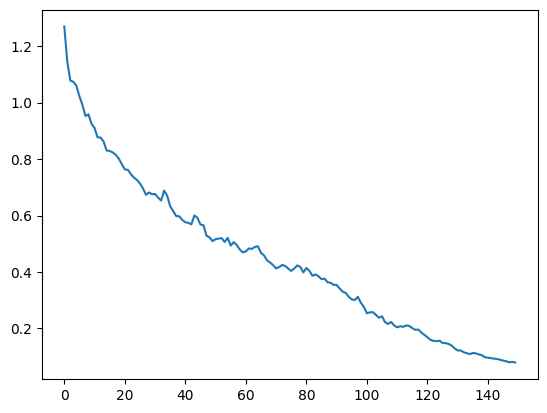

In [55]:
#TRAINING LOOP
epochs = 150
loss_values = []
for epoch in range(epochs):
    cumulative_loss = 0
    tot = 0
    pbar = tqdm(total=len(train_loader), desc=f'Epoch {epoch}')
    net.train()
    for batch_index, (image, mask, _) in enumerate(train_loader):
        tot+=1
        image, mask = image.to(device), mask.to(device)
        mask_pred = net(image)
        loss = crit(mask_pred, mask)
        cumulative_loss += loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
        pbar.update(1)
        pbar.set_postfix({'Loss': cumulative_loss/tot})
    pbar.close()
    loss_values.append(cumulative_loss/tot)
print("Training Done!")
plt.plot(loss_values)
plt.show()

In [12]:
print(len(validation_loader.dataset))
with torch.no_grad():
    net.eval()    
    for i, (x,y, index) in enumerate(validation_loader):
        x, y = x.to(device), y.to(device)
        y_pred = net(x)
        x_ref = x.cpu()
        y_pred = y_pred.squeeze().cpu()
        _,pred_mask = torch.max(y_pred, dim=0)
        fig ,axarr = plt.subplots(1,3)
        _,target_transformed_mask,_ = dataset.__getitem__(index.item())
        axarr[0].title.set_text('Original Image')
        axarr[0].imshow(x_ref.squeeze().swapaxes(0,2).swapaxes(0,1))

        axarr[1].title.set_text('Model Output')
        axarr[1].imshow(dataset.iconvert(pred_mask))

        axarr[2].title.set_text('Original Mask')
        axarr[2].imshow(dataset.iconvert(target_transformed_mask))
        
        plt.savefig("C:\\Users\\eros\\Desktop\\Models\\Output\\o{}.png".format(i))
        plt.close(fig)

2400


In [ ]:
# LOADER TEST
#image, mask,idx = next(iter(train_loader))
image, mask,idx = next(iter(validation_loader))
print(idx)
fig ,axarr = plt.subplots(1,2)
axarr[0].imshow(image.squeeze().swapaxes(0,2).swapaxes(0,1))
axarr[1].imshow(dataset.iconvert(mask.squeeze()))
plt.show()

In [56]:
torch.save(net, "C:\\Users\\eros\\Desktop\\Models\\urnet2.pt")

In [61]:
with open("loss.txt", "w") as f:
    for value in loss_values:
        f.write(str(value)+"\n")

In [62]:
torch.save({
            'epoch': 150,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': 0.079,
            }, "C:\\Users\\eros\\Desktop\\Models\\urnet2\\checkpoint1")